In [1]:
DATE = "2021-08-24"
TASK = "assess-convergence"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")

"/home/jovyan/2021-08-24-assess-convergence"

In [2]:
import Pkg
pkgs = [
#     "BioAlignments",
    "BioSequences",
#     "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
#     "DataFrames",
#     "DataStructures",
    "Dates",
#     "DelimitedFiles",
#     "Distances",
#     "EzXML",
    "FASTX",
#     "GFF3",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
    "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
#     "StatsPlots",
#     "StringDistances",
#     "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
if Sys.isapple()
    BANDAGE = "/Applications/Bandage.app/Contents/MacOS/Bandage"
else
    BANDAGE = "Bandage"
end

"Bandage"

In [4]:
function assess_kmer_sparsity_in_reads(k, observations)
#     @show k, observations
    canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations)
#     canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, first(observations))
# #     @show canonical_kmer_counts
#     for i in 2:length(observations)
#         canonical_kmer_counts_ = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations[i])
#         canonical_kmer_counts = merge!(+, canonical_kmer_counts, canonical_kmer_counts_)
#     end
#     canonical_kmer_counts = map(o -> Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, o), observations)...)
    total_observed_canonical_kmers = length(keys(canonical_kmer_counts))
    total_possible_canonical_kmers = (4^k)/2
    sparsity = round(total_observed_canonical_kmers/total_possible_canonical_kmers*100, sigdigits=3)
    @show sparsity
    return sparsity
end

assess_kmer_sparsity_in_reads (generic function with 1 method)

In [5]:
function sequence_to_canonical_kmers(kmer_type, sequence)
    return (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(kmer_type, sequence))
end

sequence_to_canonical_kmers (generic function with 1 method)

In [6]:
function determine_edge_weights(graph)
    outgoing_edge_probabilities = determine_edge_weights(graph, true)
    incoming_edge_probabilities = determine_edge_weights(graph, false)
    return Dict(true => outgoing_edge_probabilities, false => incoming_edge_probabilities)
end

determine_edge_weights (generic function with 1 method)

In [7]:
function determine_edge_weights(graph, strand)
    kmers = [graph.vprops[v][:kmer] for v in LightGraphs.vertices(graph)]
    outgoing_edge_weights = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbors = []
        downstream_neighbor_weights = []
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_orientation = neighbor == canonical_neighbor
            
            neighbor_index_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_index_range)
                @assert length(neighbor_index_range) == 1
                neighbor_index = first(neighbor_index_range)
                if LightGraphs.has_edge(graph, LightGraphs.Edge(kmer_index, neighbor_index))
                    edge_orientations = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:orientations]
                    this_edge_orientation = (source_orientation = strand, destination_orientation = neighbor_orientation)
                    if this_edge_orientation in edge_orientations
                        edge_weight = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:weight]
                        outgoing_edge_weights[kmer_index, neighbor_index] = edge_weight
                    end
                end
            end
        end
    end
    return outgoing_edge_weights
end

determine_edge_weights (generic function with 2 methods)

In [8]:
function determine_edge_probabilities(edge_weights)
    edge_probabilities = deepcopy(edge_weights)
    for orientation in [true, false]
        for row in 1:size(edge_probabilities[orientation], 1)
            edge_weights = edge_probabilities[orientation][row, :]
            edge_total = sum(edge_weights)
            for (col, edge_weight) in enumerate(edge_weights)
                if edge_total > 0
                    edge_probabilities[orientation][row, col] = edge_weight/edge_total
                else
                    edge_probabilities[orientation][row, col] = 0.0
                end
            end
        end
    end
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [9]:
function random_step(current_vertex, current_orientation, step_probabilities)
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][current_vertex, :]
    chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
    possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
    possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
    chosen_orientation = rand(possible_orientations).destination_orientation
    chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
    return chosen_oriented_step
end

random_step (generic function with 1 method)

In [10]:
function random_walk(observation_graph, initial_vertex, initial_orientation, step_probabilities; n_steps=size(step_probabilities[true], 1))
    step_count = 0
    outgoing_edge_likelihoods = step_probabilities[initial_orientation][initial_vertex, :]
    walk = Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}()
    done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    current_vertex = initial_vertex
    current_orientation = initial_orientation
    while !done
#         @show "choosing"
        chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
        chosen_step
        possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
        possible_orientations
        current_orientation
        possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
        possible_orientations
        chosen_orientation = rand(possible_orientations).destination_orientation
        chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
        push!(walk, chosen_oriented_step)
        current_vertex = chosen_step
        current_orientation = chosen_orientation
        outgoing_edge_likelihoods = step_probabilities[last(walk).orientation][last(walk).vertex, :]
        step_count += 1
#         @show outgoing_edge_likelihoods
        done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    end
    return walk
end

random_walk (generic function with 1 method)

In [11]:
# generate a genome
sequence_length = 1000
sequence = BioSequences.randdnaseq(Random.seed!(sequence_length), sequence_length)
sequence_id = string(hash(sequence))
fasta_record = FASTX.FASTA.Record(sequence_id, sequence)

FASTX.FASTA.Record:
   identifier: 3905072901333009698
  description: <missing>
     sequence: GGCGCGTGCTAGCGGTGTGGTTCTACATTGTATTGTATT…

In [12]:
reference_fasta_file = "$(DIR)/LENGTH-$(sequence_length).fasta"
open(reference_fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    write(fastx_io, fasta_record)
    close(fastx_io)
end

In [13]:
# randomly sample reads with errors from the genome
# 1%
error_rate = 0.01
n_reads = 100

# observations = [Mycelia.observe(FASTX.sequence(record), error_rate = error_rate) for i in 1:n_reads]
observations = [Mycelia.observe(fasta_record, error_rate = error_rate) for i in 1:n_reads];

In [14]:
# determine distribution of read lengths

In [15]:
median_read_length = Statistics.median(length.(FASTX.sequence.(observations)))
std_deviation_read_length = Statistics.std(length.(FASTX.sequence.(observations)))
captures_99_percent_of_reads = Int(floor(median_read_length - 4*std_deviation_read_length))

990

In [16]:
# determine optimal k
min_k = min(7, captures_99_percent_of_reads)
max_k = min(61, captures_99_percent_of_reads)
k_options = Primes.primes(min_k, max_k)
k_index = findfirst(k -> assess_kmer_sparsity_in_reads(k, observations) < .01, k_options)
k = k_options[k_index]
@show k

sparsity = 50.8
sparsity = 0.433
sparsity = 0.0318
sparsity = 0.00016
k = 17


17

In [17]:
observations_file = "$(DIR)/LENGTH-$(sequence_length)-DEPTH-$(n_reads).fastq"
open(observations_file, "w") do io
    fastq_io = FASTX.FASTQ.Writer(io)
    for record in observations
        write(fastq_io, record)
    end
    close(fastq_io)
end

# Begin graph resolving of observation graph

In [18]:
observation_graph = Mycelia.fastx_to_simple_kmer_graph(BioSequences.DNAMer{k}, observations_file)

┌ Info: creating graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:3014


{13709, 28906} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [19]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

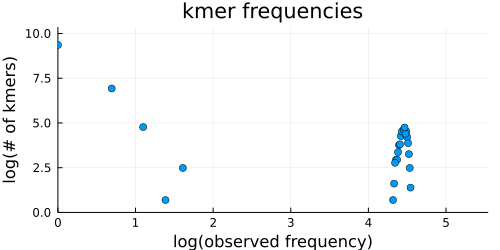

In [20]:
kmer_counts = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [21]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

0.9282223356918813

In [22]:
# step 1, hard-filter singletons

In [23]:
filtered_vertices = findall(v -> observation_graph.vprops[v][:weight] >= 5, LightGraphs.vertices(observation_graph))

996-element Vector{Int64}:
    13
    25
    44
    59
    74
    89
    99
   110
   122
   145
   163
   174
   188
     ⋮
 13542
 13559
 13585
 13590
 13599
 13622
 13635
 13644
 13645
 13650
 13663
 13689

In [24]:
filtered_observation_graph, vertex_map = LightGraphs.induced_subgraph(observation_graph, filtered_vertices)

({996, 1990} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), [13, 25, 44, 59, 74, 89, 99, 110, 122, 145  …  13585, 13590, 13599, 13622, 13635, 13644, 13645, 13650, 13663, 13689])

In [25]:
# visualize
gfa_file = observations_file * ".k-$k.filtered.gfa"
Mycelia.graph_to_gfa(filtered_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

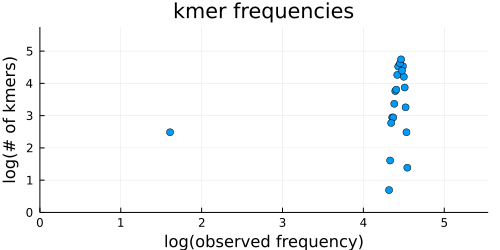

In [26]:
kmer_counts = Dict(filtered_observation_graph.vprops[v][:kmer] => filtered_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(filtered_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [27]:
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

0.012048192771084376

In [28]:
# step 2, re-simulate reads as a means of error correction

In [29]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

996-element Vector{Float64}:
 0.0009827369816950437
 0.0010300978000899856
 0.0010064173908925147
 0.0009945771862937792
 0.0009708967770963083
 0.0010537782092874565
 0.0010774586184849274
 0.0009590565724975728
 0.0010182575954912501
 0.001041938004688721
 0.0010182575954912501
 0.0009827369816950437
 0.0009235359587013664
 ⋮
 0.0010064173908925147
 0.0009945771862937792
 0.0009945771862937792
 0.0010774586184849274
 0.0009708967770963083
 0.0009590565724975728
 0.0009945771862937792
 0.0010064173908925147
 0.0010300978000899856
 0.0010064173908925147
 0.0008998555495038955
 0.0010774586184849274

In [30]:
edge_weights = determine_edge_weights(filtered_observation_graph)

Dict{Bool, SparseArrays.SparseMatrixCSC{Float64, Int64}} with 2 entries:
  0 => …
  1 => …

In [31]:
edge_weights[true]

996×996 SparseArrays.SparseMatrixCSC{Float64, Int64} with 995 stored entries:
⠉⠓⠒⠦⢤⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠄⠁⡀⠀⠈⠉⠑⠒⡦⠤⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⡀⡬⢀⠁⠀⠀⠁⠄⠀⠐⠨⠉⠑⠖⠦⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠄⠐⠀⠀⠀⠈⠐⠀⡢⠀⠂⠂⠂⠄⠀⢁⠉⠉⠲⢤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⡀⠀⠎⠁⠠⠠⠀⠈⠀⠅⠢⢣⠀⢀⠁⠀⠀⠂⠁⠉⠓⢰⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠁⠄⠐⠀⠀⡂⠀⠀⠀⠥⠀⠂⢀⠄⠀⠀⡈⠄⠁⡀⠀⠀⠄⢀⠠⠘⠉⠳⠦⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⢀⠀⠈⠊⡀⠀⠄⡄⠐⠀⢀⠢⡀⠀⠀⠀⠀⠄⠀⠀⠘⠁⠈⠉⠁⠀⠀⠐⠆⠄⠙⡖⣦⣀⠀⠀
⠀⠀⠀⠀⠀⠂⠨⠀⠄⠄⠠⠀⠠⡐⠀⡠⠄⠂⠀⠀⠀⠠⠅⠹⠀⠀⠈⠂⠀⠊⠀⠀⢡⠠⢎⣐⣁⠊⠓⡀
⠀⠀⠀⠀⢀⠄⠈⠄⠬⣂⠀⠔⠀⠈⠠⠁⠀⠀⠀⠀⠀⠀⠀⡆⡰⠀⠄⢁⢧⠁⠀⠀⠙⠁⠀⡂⠈⡃⢰⢣
⠀⠉⠀⠉⠙⠒⠖⢤⠠⢤⢠⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁
⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠂⠌⠉⠍⠓⡲⠄⠤⢠⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠠⠀⠁⠠⠀⠀⣅⡁⠠⠤⠀⠀⠉⠉⠙⠒⠲⢤⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠖⠀⠀⠀⠐⠊⠀⠀⠀⠀⠀⠀⠀⠀⠁⢈⢙⠒⠢⠤⣄⡀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⢀⠀⢁⡆⠀⠢⠀⠄⢁⠀⠀⠀⠀⠀⠀⡁⢀⠄⠁⠅⠠⠀⠀⠀⠟⠝⠶⠄⣀⠀⠀
⡀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢀⠂⠁⠀⡠⠀⠍⠓⠀⠀⠀⠀⠀⠀⠀⠐⠁⡁⠠⡢⠀⠀⠀⠐⢠⠠⡱⠎⠁⣆
⠁⠉⠀⠉⠁⠙⠒⠒⠂⠤⠤⣤⣀⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠅⠁⡚⠟⠀⠉⠃⠂⠂⠂⠂⠰⠤⣤⠤⢄⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠤⢊⢱⠠⠠⠀⠀⠀⠀⠀⠀⠀⠀⠰⡅⠀⡒⠉⠁⠉⠉⠒⡢⣄⡀⠀⠀
⠤⠤⠠⢀⣀⣀⠀⣀⡀⠀⠀⠀⠀⠘⠡⠘⠦⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⠎⠀⠀⠀⠀⠀⠹⠠⠋⠑⠐
⠀⠀⠀⠀⠀⠀⠀⠀⠉⠁⠁⠉⠉⠁⠘⠐⠰⢒⠄⠐⠒⠀⠒⠀⠀⠀⠤⠄⠤⢤⠄⠀⠀⠀⠠⠀⢀⠀⠀⠀

In [32]:
edge_weights = determine_edge_weights(filtered_observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

Dict{Bool, SparseArrays.SparseMatrixCSC{Float64, Int64}} with 2 entries:
  0 => …
  1 => …

In [33]:
kmers = [filtered_observation_graph.vprops[v][:kmer] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_weights = [filtered_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(filtered_observation_graph)]
kmer_probabilities = kmer_weights ./ sum(kmer_weights)

edge_weights = determine_edge_weights(filtered_observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

step_probabilities = deepcopy(edge_probabilities)

for orientation in [true, false]
#     @show orientation
    oriented_step_probabilities = step_probabilities[orientation] 
    for row in 1:size(step_probabilities[orientation], 1)
        step_probabilities_ = step_probabilities[orientation][row, :] .* kmer_probabilities
        if sum(step_probabilities_) > 0
            step_probabilities[orientation][row, :] .= step_probabilities_ ./ sum(step_probabilities_)
        end
    end
end

In [34]:
new_records = FASTX.FASTQ.Record[]
ProgressMeter.@showprogress for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - filtered_observation_graph.gprops[:k]
    # apply a squaring penalty to kmer_weights?
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(kmer_weights.^2))
#     @show "choosing initial vertex $initial_vertex with probability $(kmer_weights[initial_vertex])"
    initial_orientation = rand(Bool)
    forward_walk = random_walk(filtered_observation_graph, initial_vertex, initial_orientation, step_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(filtered_observation_graph, initial_vertex, !initial_orientation, step_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(filtered_observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [35]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [36]:
corrected_observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, corrected_fastq_file)

┌ Info: assessing kmers
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1932
┌ Info: creating graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:1948


{984, 1966} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [37]:
# visualize
gfa_file = corrected_fastq_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(corrected_observation_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

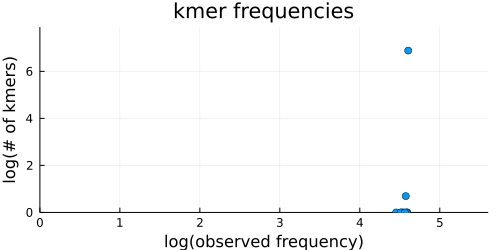

In [38]:
kmer_counts = Dict(corrected_observation_graph.vprops[v][:kmer] => corrected_observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(corrected_observation_graph))
total_observed_kmers = sum(values(kmer_counts))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_counts)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), title="kmer frequencies")

In [39]:
# compare the new graph to the error-free graph to the error-corrected graph

In [40]:
reference_kmers = keys(Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, reference_fasta_file))
distance_to_reference_graph = 1 - LSHFunctions.jaccard(Set(reference_kmers), Set(keys(kmer_counts)))

0.0

# Final polish and reduction

In [41]:
# to_filter = Int[]
connected_component = first(LightGraphs.connected_components(corrected_observation_graph))

984-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 973
 974
 975
 976
 977
 978
 979
 980
 981
 982
 983
 984

In [42]:
tip_vertices = filter(v -> LightGraphs.degree(corrected_observation_graph, v) == 2, LightGraphs.vertices(corrected_observation_graph))

2-element Vector{Int64}:
 469
 532

In [47]:
if length(tip_vertices) > 2
    component_weights = map(v -> corrected_observation_graph.vprops[v][:weight], connected_component)
    component_median = Statistics.median(component_weights)
    component_standard_deviation = Statistics.std(component_weights)
    tips_to_drop = filter(tip -> corrected_observation_graph.vprops[tip][:weight] < component_median - 2*component_standard_deviation, tip_vertices) 
    polished_graph, vertex_map = LightGraphs.induced_subgraph(corrected_observation_graph, setdiff(LightGraphs.vertices(corrected_observation_graph), tips_to_drop))
    simplified_graph = Mycelia.simplify_kmer_graph(polished_graph)
else
    simplified_graph = Mycelia.simplify_kmer_graph(corrected_observation_graph)
end

┌ Info: simplifying kmer graph
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2260
┌ Info: resolving untigs...
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2261


  0.461541 seconds (408.90 k allocations: 24.854 MiB, 9.24% gc time, 97.22% compilation time)


┌ Info: determining untig orientations...
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2264


  0.335142 seconds (464.49 k allocations: 25.522 MiB, 97.88% compilation time)


┌ Info: initializing graph node metadata
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2269
┌ Info: creating simplified unitgs to help resolve connections
└ @ Mycelia /home/jovyan/git/Mycelia/src/Mycelia.jl:2279


{1, 0} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [48]:
# write simplified graph to gfa
# visualize
gfa_file = corrected_fastq_file * ".k-$k.simplified.gfa"
Mycelia.graph_to_gfa(simplified_graph, gfa_file)

run(`$(BANDAGE) image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [49]:
simplified_graph.vprops[1][:weight]

100.0

In [52]:
Mycelia.is_equivalent(FASTX.sequence(fasta_record), simplified_graph.vprops[1][:sequence])

true

# THE SAME!!!

In [53]:
# write contigs to fasta
final_fasta_file = corrected_fastq_file * ".k-$k.simplified.fasta"
open(final_fasta_file, "w") do io
    fasta_io = FASTX.FASTA.Writer(io)
    for vertex in LightGraphs.vertices(simplified_graph)
        seq = simplified_graph.vprops[vertex][:sequence]
        description = string(simplified_graph.vprops[vertex][:weight])
        id = string(hash(seq)) * '-' * string(Dates.now())
        record = FASTX.FASTA.Record(id, description, seq)
        @show record
        write(fasta_io, record)
    end
    close(fasta_io)
end

record = FASTX.FASTA.Record:
   identifier: 7865558533970300004-2021-08-24T00:42:51.550
  description: 100.0
     sequence: CCACCATCATCGTCGGATCTAATACCCGTGGGTGGATAC…
